In [1]:
import torch
import matplotlib.pyplot as plt
import numpy as np
from data.ffs.readParameters import readParametersFromFileName
from ffsInference import ffsInference
parameterDef = {'name': str, 're': float, 'Lo': float, 'Ho': float}
from upt.datasets.ffs_dataset import ffsDataset


In [2]:
from upt.datasets.ffs_dataset import ffsDataset

# crop_values= [[-6, -2], [12, 2]]
crop_values= [[-2, -2], [2, 2]]

xMin = crop_values[0][0]
xMax = crop_values[0][1]

# num_test_inputs  = 4096
# num_test_outputs = 4096
# num_train_inputs  = num_test_inputs 
# num_train_outputs = num_test_outputs

test_hr_dataset = ffsDataset(
    root="./data/ffs/preprocessed600",
    # how many inputs to use for training
    # num_inputs=float("inf"),
    num_inputs=10000,
    # how many outputs to use for training
    # num_outputs=float("inf"),
    num_outputs=10000,
    # mode
    mode="test",
    crop_values=crop_values,
)
from torch.utils.data import DataLoader
from upt.collators.ffs_collator import ffsCollator

# get test sample
test_dataloader = DataLoader(
    dataset=test_hr_dataset,
    batch_size=1,
    collate_fn=ffsCollator(num_supernodes=512, deterministic=True),
)
data = [d for d in test_dataloader]

In [3]:
batch = data[2]

input_pos = test_hr_dataset.denormalize_pos(batch['input_pos'])
input_feat = test_hr_dataset.denormalize_sdf(batch['input_feat'])
output_pos = test_hr_dataset.denormalize_pos(batch['output_pos'][0])
target_feat = test_hr_dataset.denormalize_feat(batch['target_feat'])
re = test_hr_dataset.denormalize_re(batch['re'])
parameterDict = readParametersFromFileName(batch['name'][0], parameterDef)
re = parameterDict['re']
Lo = parameterDict['Lo']
Ho = parameterDict['Ho']
print(re)
print(batch['name'][0])

831.2500000000047
DP445_831,25000000000466_0,7166666666666679_0,39633333333333476


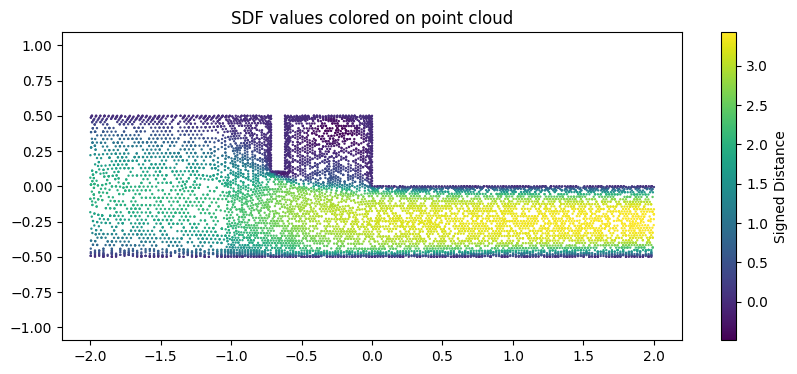

In [4]:
import matplotlib.pyplot as plt
var = target_feat[:,0]
coord = output_pos

# var = input_feat
# coord = input_pos
# Visualize
plt.figure(figsize=(10, 4))
plt.scatter(coord[:, 0], coord[:, 1], c=var, s=0.5)
plt.colorbar(label="Signed Distance")
plt.axis("equal")
plt.title("SDF values colored on point cloud")
plt.show()

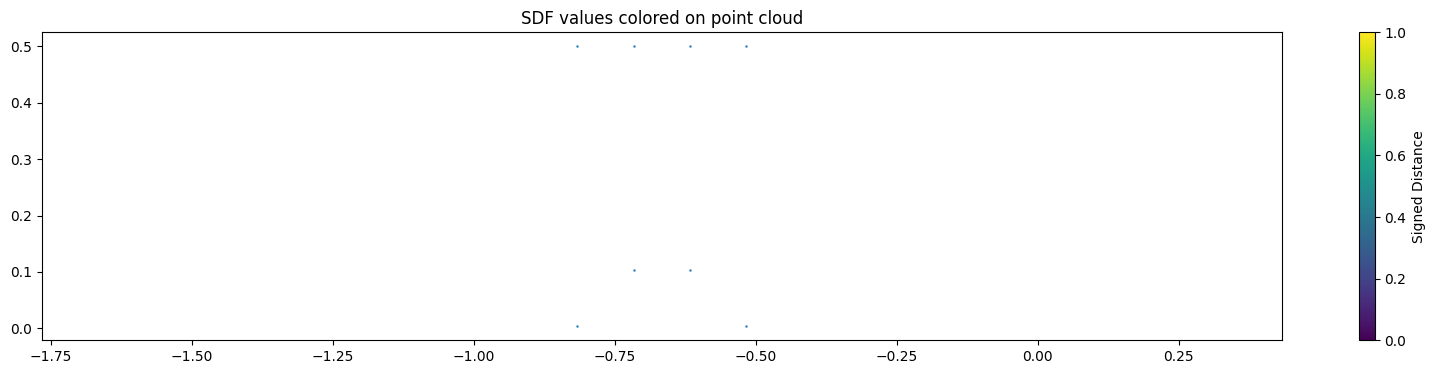

In [5]:
Wo = 0.1
thichness = 0.1 
usx = -Lo - thichness
dsx = -Lo + Wo + thichness
y = 0.5 - Ho - thichness


bPoints = np.array([
    [usx, 0.5], [-Lo, 0.5], [-Lo, 0.5 - Ho],
    [-Lo + Wo, 0.5 - Ho], [-Lo + Wo, 0.5], [dsx, 0.5],
    [dsx, y], [usx, y]
])

# Visualize
plt.figure(figsize=(20, 4))
plt.scatter(bPoints[:, 0], bPoints[:, 1], s=0.5)
plt.colorbar(label="Signed Distance")
plt.axis("equal")
plt.title("SDF values colored on point cloud")
plt.show()

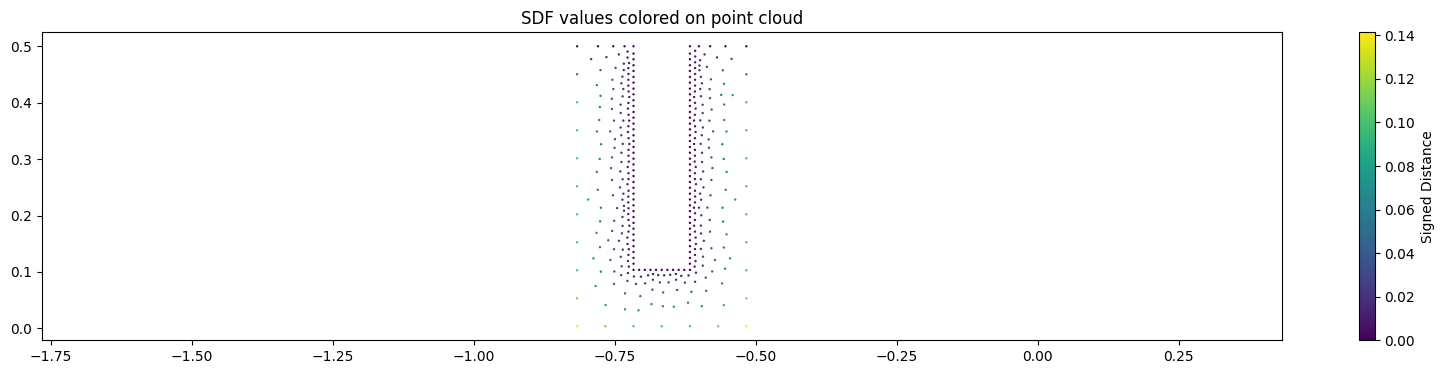

In [6]:

# test_batch = data[9]
# name = test_batch['name'][0]
# paramDef = {'name': str, 're': float, 'Lo': float, 'Ho': float}
# from data.ffs.readParameters import readParametersFromFileName
# parameters = readParametersFromFileName(name, paramDef)

# re = parameters['re']
# Lo = parameters['Lo']
# Ho = parameters['Ho']

from ffsInference import ffsInference

inferencer = ffsInference(
    train_dataset=test_hr_dataset,
    totalPoints=40000,
    numSupernodes=512,
)

meshParameters = {'size': 0.05, 'lcmin':0.01, 'lcmax':0.05, 'distmin':0.005, 'distmax':0.1, 'curveIdxs': [0,11]}

parameter_sets = [(re, Lo, Ho)]  # Example parameter sets
batches = inferencer.get_batches(parameter_sets=parameter_sets, useMesh=True, meshParameters=meshParameters)
batch = batches[0]

# input_pos = batch['input_pos']
# input_feat = batch['input_feat']

input_pos = test_hr_dataset.denormalize_pos(batch['input_pos'])
input_feat = test_hr_dataset.denormalize_sdf(batch['input_feat'])

# Visualize
plt.figure(figsize=(20, 4))
plt.scatter(input_pos[:, 0], input_pos[:, 1], c=input_feat, s=0.5)
plt.colorbar(label="Signed Distance")
plt.axis("equal")
plt.title("SDF values colored on point cloud")
plt.show()
# ['892.50000000000591', '0.87000000000000477', '0.33700000000000008']


In [6]:
import os
from pathlib import Path
import torch
root = Path('./data/ffs/preprocessed600/')

uris = []
for name in sorted(os.listdir(root)):
    sampleDir = root / name
    if sampleDir.is_dir():
        uris.append(sampleDir)

sum_vars = 0.0
sum_sq_vars = 0.0
total_samples = 0
for uri in uris:
    sdf = torch.load(uri / 'mesh_sdf.th', weights_only=True)
    sum_vars += sdf.sum()
    sum_sq_vars += (sdf ** 2).sum()
    total_samples += len(sdf)
mean_vars = sum_vars / total_samples
std_vars = torch.sqrt((sum_sq_vars / total_samples) - (mean_vars ** 2))
other = torch.load(root/'vars_norm.th', weights_only=True)
other['mean'][-1] = mean_vars
other['std'][-1] = std_vars
torch.save(other, root/"vars_norm.th")


In [36]:
from pathlib import Path

root = Path('./data/ffs/preprocessed/')

for oldName in sorted(root.iterdir()):
    if oldName.is_dir():
        newName = oldName.name.replace('-', '_')
        newPath = oldName.parent / newName
        oldName.rename(newPath)

In [ ]:
from pathlib import Path

dir_path = Path("path/to/your/folder")

if dir_path.exists() and dir_path.is_dir():
    shutil.rmtree(dir_path)

In [19]:
from pathlib import Path
import shutil


root = Path('./data/ffs/preprocessed/')

for name in sorted(root.iterdir()):
    if name.is_dir() and '-' in name.name:
        shutil.rmtree(name)
        print(name)

data/ffs/preprocessed/DP100_699,9999999999992-0,93818181818181645-0,46181818181818091
data/ffs/preprocessed/DP10_463,63636363636368-0,45818181818181825-0,13454545454545455
data/ffs/preprocessed/DP11_563,63636363636363-0,989090909090907-0,13818181818181818
data/ffs/preprocessed/DP12_336,36363636363637-0,99636363636363523-0,14181818181818184
data/ffs/preprocessed/DP13_372,72727272727275-0,69090909090909047-0,14545454545454548
data/ffs/preprocessed/DP14_754,54545454545348-0,59636363636363643-0,14909090909090911
data/ffs/preprocessed/DP154_482,49999999999994-0,38-0,11000000000000001
data/ffs/preprocessed/DP155_662,5-0,74-0,13
data/ffs/preprocessed/DP156_437,5-0,26-0,15000000000000002
data/ffs/preprocessed/DP157_617,5-0,90000000000000013-0,17
data/ffs/preprocessed/DP158_752,50000000000011-0,78-0,19
data/ffs/preprocessed/DP159_932,50000000000023-0,65999999999999992-0,21000000000000002
data/ffs/preprocessed/DP15_263,63636363636368-0,27636363636363637-0,15272727272727274
data/ffs/preprocessed/